## Setup

In [25]:
import os
import datetime
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.signal import savgol_filter
import random

# mapping '/' to __truediv__()
from __future__ import division 

from sklearn.metrics import mean_absolute_error
# possible alternative to above:
# tf.metrics.MeanAbsoluteError()

# helper code
from WindowGenerator import WindowGenerator
from Baseline import Baseline
from ModelGenerator import ModelGenerator

mpl.rcParams['figure.figsize'] = (12, 3)
mpl.rcParams['axes.grid'] = False

VERBOSE = True
MAX_EPOCHS = 30
INPUT_WIDTH = 3
SHIFT = 8
LABEL_WIDTH = 1
WINDOW_SIZE = INPUT_WIDTH + SHIFT

if VERBOSE:
    print('Setup Complete')

Setup Complete


## Import, Process, Graph

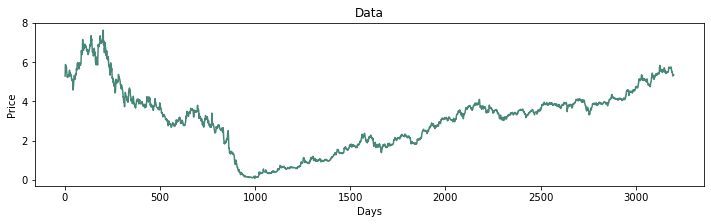

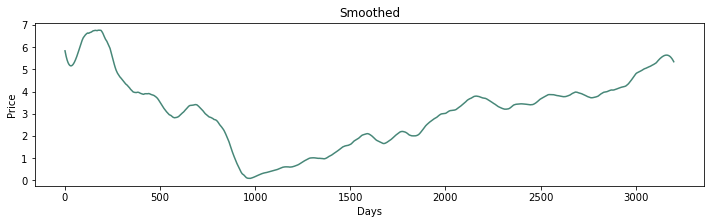

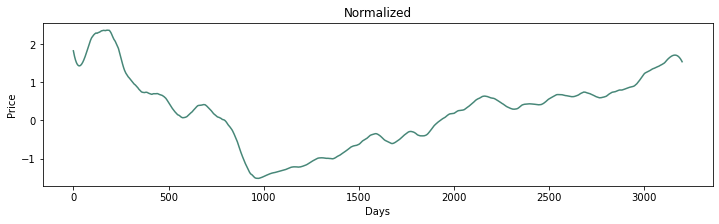

0      2005-02-25
1      2005-02-28
2      2005-03-01
3      2005-03-02
4      2005-03-03
          ...    
3196   2017-11-06
3197   2017-11-07
3198   2017-11-08
3199   2017-11-09
3200   2017-11-10
Name: ds, Length: 3201, dtype: datetime64[ns]
total samples = 3201
----------------------------------------
train_df samples = 2240
val_df samples = 640
test_df samples = 321
----------------------------------------
train + val + test = 3201


In [69]:
df = pd.read_csv('data/siri_edit.csv')
# print(df)

# throw out some data
start = 0 # 0
end = len(df['y']) # len(df['y'])
df_len = len(df['y'])
df = df.drop(index=range(0, start))
# print(df)
df = df.drop(index=range(end, df_len))
# print(df)
df = df.set_index(np.arange(0, len(df['y'])))
# print(df)

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

plt.title('Data')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

plt.title('Smoothed')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# split
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# normalize
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

plt.title('Normalized')
df_std = (df - train_mean) / train_std
y = df_std['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

if VERBOSE:
    print( date_time )
    print( "total samples = {0:d}".format( n ) )
    print( "----------------------------------------" )
    print( "train_df samples = {0:d}".format( len( train_df ) ) )
    print( "val_df samples = {0:d}".format( len( val_df ) ) )
    print( "test_df samples = {0:d}".format( len( test_df ) ) )
    print( "----------------------------------------" )
    print( "train + val + test = {0:d}".format( len( train_df ) + len( val_df ) + len( test_df ) ) )

## Frequency

frequencies: 1501
years: 11.952191235059761


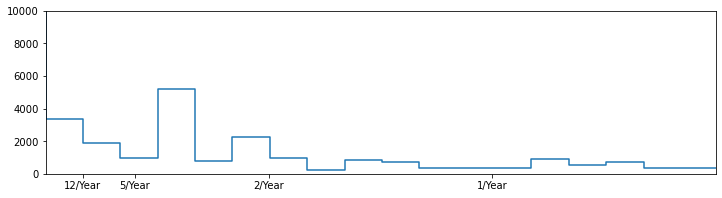

In [6]:
fft = tf.signal.rfft(df['y'])

# range for ibm: [10000:12000]

f_per_dataset = np.arange(0, len(fft))
n_samples_d = len(df['y'])
busi_days_per_year = 251 # less than business days but close to correct # of years
years_per_dataset = n_samples_d/(busi_days_per_year)
f_per_year = f_per_dataset/years_per_dataset

if VERBOSE:
    print(f'frequencies: {len(fft)}') # data_length / 2 + 1
    print(f'years: {years_per_dataset}')
    # print(f_per_year)

plt.step(f_per_year, np.abs(fft))
plt.ylim(0, 10000)
plt.xlim([0.001, 1.5])
plt.xticks([0.083, 0.2, 0.5, 1], labels=['12/Year', '5/Year', '2/Year', '1/Year']) # f = 1/#years
plt.show()

## Make Model and Compile

In [7]:
model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                            shift=SHIFT, max_epochs=MAX_EPOCHS, label_columns=['y'])
if VERBOSE:
    print(model.conv_window)

Total window size: 11
Input indices: [0 1 2]
Label indices: [10]
Label column name(s): ['y']


mean absolute error (test): 0.070
adjusted mae (test): 1.203


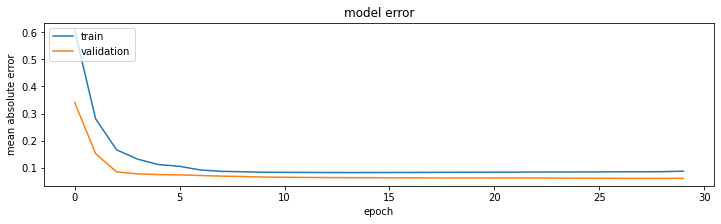

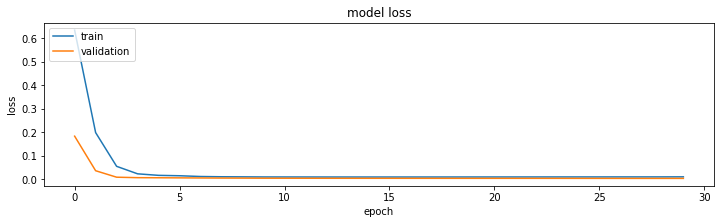

In [5]:
# train and eval model
history = model.compile_and_fit()
IPython.display.clear_output()

# use model on test
y, y_p, mae = model.test_model()
print( "mean absolute error (test): {0:0.3f}".format( mae ) )
print(f'adjusted mae (test): {round(float(mae*train_mean), 3)}')

plt.title('model error')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test Results

mean absolute error (test): 0.070
adjusted mae (test): 1.203


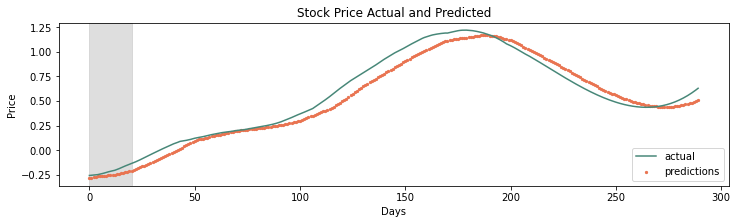

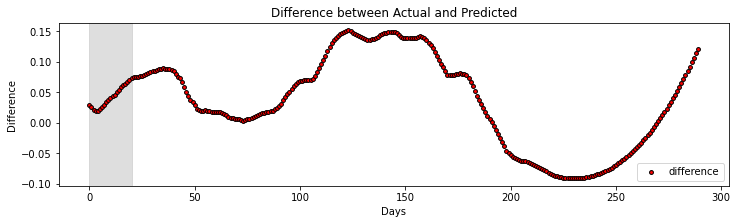

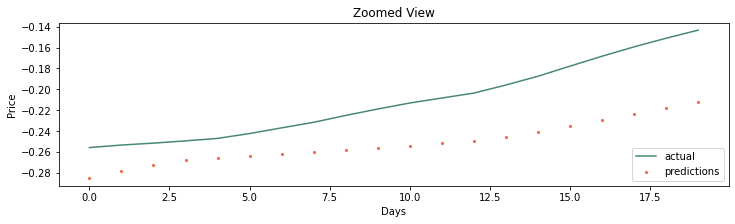

In [6]:
print( "mean absolute error (test): {0:0.3f}".format( mae ) )
print(f'adjusted mae (test): {round(float(mae*train_mean), 3)}')

x = np.arange( 0, len(y), 1 )
zoom_pwr = 14
zoom_idx = int(np.floor(len(y)/zoom_pwr))
x_zoom = np.arange(0, zoom_idx, 1)
y_zoom = y[: zoom_idx]
y_p_zoom = y_p[: zoom_idx]
shd_alpha = 0.6

plt.title('Stock Price Actual and Predicted')
plt.ylabel('Price')
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
p1, = plt.plot( x, y, label='test', color='#478778' )
p2 = plt.scatter( x, y_p, edgecolors='#E97451', color='#E97451', s=5 )
plt.legend(handles=[p1, p2], labels=['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Difference between Actual and Predicted')
plt.ylabel('Difference')
p1 = plt.scatter( x, ( y-y_p ), edgecolors='black', color='red', s=15 )
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
plt.legend(handles=[p1], labels=['difference'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Zoomed View')
plt.ylabel('Price')
plt.plot( x_zoom, y_zoom, label='test', color='#478778' )
plt.scatter( x_zoom, y_p_zoom, edgecolors='#E97451', color='#E97451', s=5)
plt.legend(['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

## Real World Test
Make a single prediction based on the history of a different stock.

              ds        y
3340  1975-05-14  0.78885
3341  1975-05-15  0.78885
3342  1975-05-16  0.77710
3343  1975-05-19  0.76875
3344  1975-05-20  0.76875
3345  1975-05-21  0.74880
3346  1975-05-22  0.75280
3347  1975-05-23  0.76095
3348  1975-05-27  0.76095
3349  1975-05-28  0.75695
3350  1975-05-29  0.75280

Prediction:        0.7638


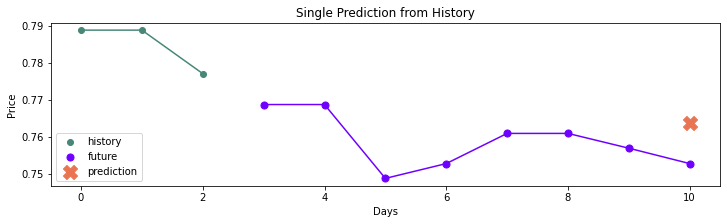

In [7]:
# specify pathname
pathname = 'data/ge_edit.csv'
df = pd.read_csv(pathname)
df_len = len(df['y'])

# adjust start_idx to pick a different range of values
start_idx = random.randint(0,len(df['y'])-WINDOW_SIZE)

start_idx = min(start_idx, len(df['y'])-WINDOW_SIZE)
start_idx = max(start_idx, 0)
# drop beginning
df = df.drop(index=range(0, start_idx))
# drop end
df = df.drop(index=range(start_idx+WINDOW_SIZE, df_len))

print(df)

# seperates date_time from df
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp_s = date_time.map(datetime.datetime.timestamp)

# divide dataframe
input_df = df[:INPUT_WIDTH]
future_df = df[INPUT_WIDTH:] # pretend we don't know these future values

# make prediction
y_p = model.single_window(df)

# history
y = input_df.to_numpy()
x = np.arange(0, len(y), 1)
# future
y_f = future_df.to_numpy()
x_f = np.arange(len(y), len(y) + len(y_f), 1)
# prediction
y_p = np.array( y_p )
x_p = WINDOW_SIZE-1

if VERBOSE:
    y_p_format = "{:.4f}".format(y_p[0])
    print(f"\nPrediction:        {y_p_format}")

# plot
plt.title('Single Prediction from History')
plt.ylabel('Price')
s1 = plt.scatter(x, y, edgecolors='#478778', color='#478778')
plt.plot(x, y, color='#478778')
s2 = plt.scatter(x_f, y_f, edgecolors='#6F00FF', color='#6F00FF', s=50)
plt.plot(x_f, y_f, color='#6F00FF')
s3 = plt.scatter(x_p, y_p, edgecolors='#E97451', color='#E97451', s=200, marker='X', zorder=10)
plt.legend(handles=[s1, s2, s3], labels=['history', 'future', 'prediction'], loc='lower left')
plt.xlabel('Days')
plt.show()

## Window Testing Loop
Test different window configs and record results.

In [ ]:
grid = []

for shift_idx in range(0,14+1):
    row = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=shift_idx, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        row.append(mae)
    grid.append(row)
grid = np.array(grid)
np.save('data/perf_grid.npy', grid)
if VERBOSE:
    print('Done!')
# print(grid)

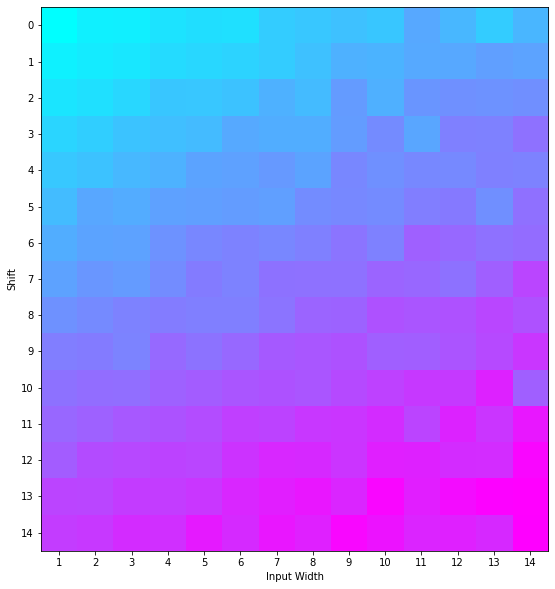

In [8]:
# load grid from drive
grid = np.load('data/perf_grid.npy')

plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='cool', interpolation='nearest')
plt.yticks(range(0,14+1), range(0,14+1))
plt.xticks(range(0,13+1), range(1,14+1))
plt.xlabel('Input Width')
plt.ylabel('Shift')
plt.show()

## Chunks
Use data in chunks of 1k or 2k.

In [21]:
df = pd.read_csv('data/ibm_edit.csv')

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

# make chunks
chunk_size = 2000
chunk_size = min(chunk_size, len(df['y']))
chunk_size = max(chunk_size, 1)
df_list = []
for i in range(0, len(df['y']), chunk_size):
    df_temp = df.drop(index=range(0, i))
    df_temp = df_temp.drop(index=range(i+chunk_size, len(df['y'])))
    df_temp = df_temp.set_index(np.arange(0, len(df_temp['y'])))
#     print(df_temp)
    df_list.append(df_temp)
# print(df_list)

# throw out small chunk
if (len(df_list[-1] < chunk_size)):
    df_list.pop(-1)

# ML with chunks
mae_list = []
for df in df_list:
    
    # split
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    # normalize
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # compile
    model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                            shift=SHIFT, max_epochs=MAX_EPOCHS, label_columns=['y'])
    history = model.compile_and_fit()
    IPython.display.clear_output()
    y, y_p, mae = model.test_model()
    mae = mae*train_mean
    mae_list.append(mae)

if VERBOSE:
    print("Done!")

Done!


In [22]:
i = 1
for num in mae_list:
    print(f"mae {i}: {round(num.at['y'], 4)}")
    i = i+1

mae 1: 1.7472
mae 2: 0.3343
mae 3: 2.5194
mae 4: 6.3045
mae 5: 3.5205
mae 6: 15.499
mae 7: 14.0145


## Optimal Window Analysis

In [8]:
grid = []
shift_vals = [1,2,3,7,14,21]

for shift_idx in shift_vals:
    row = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=shift_idx, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        row.append(mae)
    grid.append(row)
grid = np.array(grid)
np.save('data/opt_perf_grid.npy', grid)
if VERBOSE:
    print('Done!')
# print(grid)

Done!


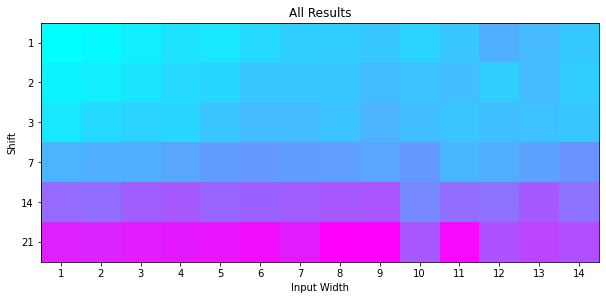

Best Widths:

   Width    MAE
0      1  0.148
1      1  0.295
2      1  0.420
3     11  0.972
4     10  1.460
5     10  1.997


In [92]:
# load grid from drive
grid = np.load('data/opt_perf_grid.npy')
# print(grid)

plt.figure(figsize=(10,10))
plt.title('All Results')
plt.imshow(grid, cmap='cool', interpolation='nearest')
plt.yticks(range(0,5+1), shift_vals)
plt.xticks(range(0,13+1), range(1,14+1))
plt.xlabel('Input Width')
plt.ylabel('Shift')
plt.show()

best_widths = []
for sub_grid in grid:
    min_val = sys.maxsize
    count = 1
    for val_array in sub_grid:
        val = val_array[0]
        if val < min_val:
            best_width = count
            min_val = val
        count += 1
    best_widths.append([best_width, min_val])

temp = pd.DataFrame(best_widths)
temp.rename(columns={0:'Width',
                     1:'MAE'}, inplace=True)
temp['MAE'] = temp['MAE'].astype(float).round(3)

print('Best Widths:\n')
print(temp)

## Multiple Stock Spreadsheet

In [87]:
stock_list = ["adbe",
             "all",
             "amd",
             "amzn",
             "csco",
             "ebay",
             "ge",
             "googl",
             "grmn",
             "ibm",
             "msft",
             "nke",
             "nvda",
             "orcl",
             "siri",
             "xlnx"]

In [56]:
stock_info = []
for stock_name in stock_list:
    
    ###
    ### total stats
    ###
    
    # load file
    df = pd.read_csv(f'data/{stock_name}_edit.csv')
    
    # stock data
    stock_row = [stock_name]

    # seperate date_time
    date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
    # timestamp doesn't work if data is before 1970
    if (date_time[0].year >= 1970):
        timestamp_s = date_time.map(datetime.datetime.timestamp)

    # smooth data
    df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order
    
    # split
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # normalize
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # frequencies
    fft = tf.signal.rfft(df['y'])
    fft_array = np.abs(fft.numpy())
#     print(fft_array)
    # don't know how to find x values of biggest 3 (not the same as index)
    
    # find best width for shift=21 and mae for total
    mae_list = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=21, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        mae_list.append(mae)
    
    # add best mae and width to row
    min_val = sys.maxsize
    count = 1
    for val_array in mae_list:
        val = val_array[0]
        if val < min_val:
            best_width = count
            min_mae = val
        count += 1
    stock_row.append(min_mae)
    stock_row.append(21)
    stock_row.append(best_width)
    print(stock_row)
    
    ###
    ### chunk stats
    ###
    
    # load fresh file
    df = pd.read_csv(f'data/{stock_name}_edit.csv')

    # seperate date_time
    date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
    # timestamp doesn't work if data is before 1970
    if (date_time[0].year >= 1970):
        timestamp_s = date_time.map(datetime.datetime.timestamp)

    # smooth data
    df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

    # make chunks
    chunk_size = 2000
    chunk_size = min(chunk_size, len(df['y']))
    chunk_size = max(chunk_size, 1)
    df_list = []
    for i in range(0, len(df['y']), chunk_size):
        df_temp = df.drop(index=range(0, i))
        df_temp = df_temp.drop(index=range(i+chunk_size, len(df['y'])))
        df_temp = df_temp.set_index(np.arange(0, len(df_temp['y'])))
    #     print(df_temp)
        df_list.append(df_temp)
    # print(df_list)

    # throw out small chunk
    if (len(df_list[-1] < chunk_size)):
        df_list.pop(-1)

    # ML with chunks
    mae_list_list = []
    for df in df_list:

        # split
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]

        # normalize
        train_mean = train_df.mean()
        train_std = train_df.std()
        train_df = (train_df - train_mean) / train_std
        val_df = (val_df - train_mean) / train_std
        test_df = (test_df - train_mean) / train_std
        
        # find best width for shift=21 and mae for total
        mae_list = []
        for input_width_idx in range(1,14+1):
            model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                                input_width=input_width_idx, label_width=LABEL_WIDTH, 
                                shift=21, max_epochs=MAX_EPOCHS, label_columns=['y'])
            history = model.compile_and_fit()
            IPython.display.clear_output()
            y, y_p, mae = model.test_model()
            mae = mae*train_mean
            mae_list.append(mae)
        mae_list_list.append(mae_list)
    
    # find best mae and width for each chunk
    min_mae_list = []
    best_width_list = []
    for mae_list in mae_list_list:
        min_val = sys.maxsize
        count = 1
        for val_array in mae_list:
            val = val_array[0]
            if val < min_val:
                best_width = count
                min_mae = val
            count += 1
        min_mae_list.append(min_mae)
        best_width_list.append(best_width)
    
    # find mean and stdev of best mae values
    mean_mae = np.average(min_mae_list)
    mean_width = int(round(np.average(best_width_list), 0))
    std_mae = np.std(min_mae_list)
    
    # add stats
    stock_row.append(mean_mae)
    stock_row.append(std_mae)
    stock_row.append(21)
    stock_row.append(mean_width)
    stock_info.append(stock_row)

# print(stock_info)
np.save('data/stock_info.npy', stock_info)
print("Done!")

[['adbe', 13.488996423509663, 21, 14, 3.725923274660713, 2.8247324567830785, 21, 14], ['all', 46.15913317109744, 21, 14, 14.39734869251859, 10.963273550996574, 21, 14], ['amd', 3.674747466205078, 21, 14, 2.417216712692234, 0.8860160774245058, 21, 14], ['amzn', 40.72526009386116, 21, 14, 6.231549370571295, 4.557503708848125, 21, 14], ['csco', 1.3613968456437455, 21, 14, 1.5602157178058185, 0.4049910399962679, 21, 14], ['ebay', 16.28866711024412, 21, 14, 6.853712120510541, 3.6651205344562894, 21, 14], ['ge', 1.7568348121043675, 21, 14, 2.2081894634804144, 2.134788439031721, 21, 14], ['googl', 112.31355081487584, 21, 14, 56.80776982525406, 0.0, 21, 14], ['grmn', 6.219150035407321, 21, 14, 9.115944564779644, 4.997198032116552, 21, 14], ['ibm', 4.86996233169852, 21, 14, 14.848960737205402, 13.29838930366954, 21, 14], ['msft', 7.541545272431382, 21, 14, 2.222055804619582, 1.7641715694636797, 21, 14], ['nke', 10.200725961479906, 21, 14, 1.2097282021099414, 1.1331642246647864, 21, 14], ['nvda'

In [86]:
stock_info = np.load('data/stock_info.npy')
stock_info = pd.DataFrame(stock_info_copy)
stock_info.rename(columns={0:'Name',
                           1:'MAE',
                           2:'Shift',
                           3:'Width',
                           4:'Mean MAE',
                           5:'STD MAE',
                           6:'Shift',
                           7:'Width'}, inplace=True)
stock_info['MAE'] = stock_info['MAE'].astype(float).round(3)
stock_info['Mean MAE'] = stock_info['Mean MAE'].astype(float).round(3)
stock_info['STD MAE'] = stock_info['STD MAE'].astype(float).round(3)
print(stock_info)

     Name      MAE Shift Width  Mean MAE  STD MAE Shift Width
0    adbe   13.489    21    14     3.726    2.825    21    14
1     all   46.159    21    14    14.397   10.963    21    14
2     amd    3.675    21    14     2.417    0.886    21    14
3    amzn   40.725    21    14     6.232    4.558    21    14
4    csco    1.361    21    14     1.560    0.405    21    14
5    ebay   16.289    21    14     6.854    3.665    21    14
6      ge    1.757    21    14     2.208    2.135    21    14
7   googl  112.314    21    14    56.808    0.000    21    14
8    grmn    6.219    21    14     9.116    4.997    21    14
9     ibm    4.870    21    14    14.849   13.298    21    14
10   msft    7.542    21    14     2.222    1.764    21    14
11    nke   10.201    21    14     1.210    1.133    21    14
12   nvda   58.764    21    14     4.350    3.611    21    14
13   orcl    5.601    21    14     4.002    4.010    21    14
14   siri    0.228    21    14     0.514    0.000    21    14
15   xln